In [1]:
import numpy as np
import pandas as pd
import scipy
import os
import segyio
import matplotlib.pyplot as plt

In [2]:
# data path 
data_path = 'data/R1809SA8S299.sgy'

In [3]:
# Function to read SEG-Y file
# trace_count = No of receivers, num_samples = How many reading were taken by each receiver 

def read_segy(sgyfile,textheader=None):
    dataout = None
    sampint = None
    textheader_output = None
    
    with segyio.open(sgyfile, "r", ignore_geometry=True) as f:
        # Get the number of traces and sample size
        num_traces = f.tracecount     # Number of traces 
        num_samples = f.samples.size  # Number of samples per trace
        print(f'No of traces = {num_traces}, No of samples per trace = {num_samples}')
        
        # Initialize dataout array
        dataout = np.zeros((num_traces, num_samples))
        
        # Populate the dataout with traces
        for i in range(num_traces):
            dataout[i, :] = f.trace[i]  # Fill each row with the trace data
        
        # Extracting sample interval
        delta_t = f.samples[1] - f.samples[0]  # Assuming regular sampling
        
        # Extracting text header if requested
        if textheader == 'yes':
            textheader_output = segyio.tools.wrap(f.text[0])
    return dataout,delta_t, textheader_output

In [4]:
# read data 
data, delta_t, text_header = read_segy(data_path)
data

No of traces = 15315, No of samples per trace = 3200


array([[ 1.38689709,  1.38689709,  0.46229905, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02937781,  0.0514115 ,  0.08813339, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05980509,  0.03829641,  0.07396984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01836096,  0.01416419, -0.00577066, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00472157,  0.0057705 ,  0.01206575, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02675485, -0.02045941, -0.02780414, ...,  0.        ,
         0.        ,  0.        ]])

In [5]:
# receiver array 
receiver_no = np.arange(data.shape[0])
receiver_no

array([    0,     1,     2, ..., 15312, 15313, 15314])

In [6]:
# time seperation between receiver reading (here in ms)
delta_t

2.0

In [7]:
# lets try to figure out how we get 15314 receiver count
# Here we know that no of shots = 3, so the array has 638 Receivers [the other 3 is for 3 shots reading from source]

(638*8)*3 + 3

15315

In [8]:
# plot the normalized singal from a receiver array
def plot_singal(receiver_no, x_lim=[0,6],y_lim=[-1.1,1.1]):
    signal_count = data.shape[1]                  # no of time stamps
    time = np.arange(0,signal_count)*delta_t*1e-3 # in ms
    print(f'signal detected by receivers: {receiver_no}')
    [plt.plot(time,data[r]/ max(abs(data[r]))) for r in receiver_no]
        
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.ylabel('Amplitude(normalized)')
    plt.xlabel('time(ms)')
    

### Amplitude vs time for the source 

* From [0-0.1] s you can see pure source signal 

* Then from ~ [1.5-0.3] s first bubble wave with relative amplitude 0.25 

* Finally from ~ [0.35-0.5] s the second bubble wave with relative amplitude 0.15 


signal detected by receivers: [0]


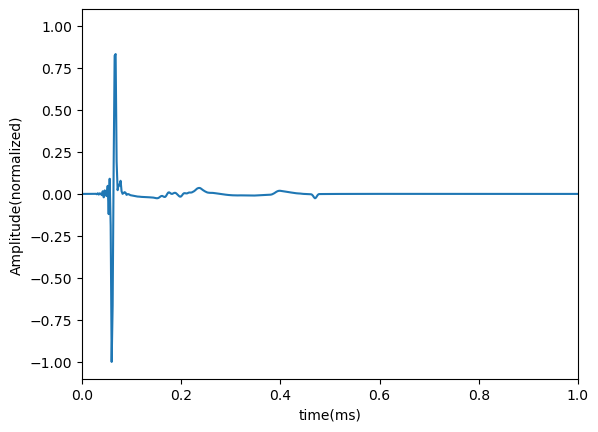

In [9]:
# plot the source signal 
plot_singal([0],x_lim=[0,1])

#### Zoom in B1 

signal detected by receivers: [0]


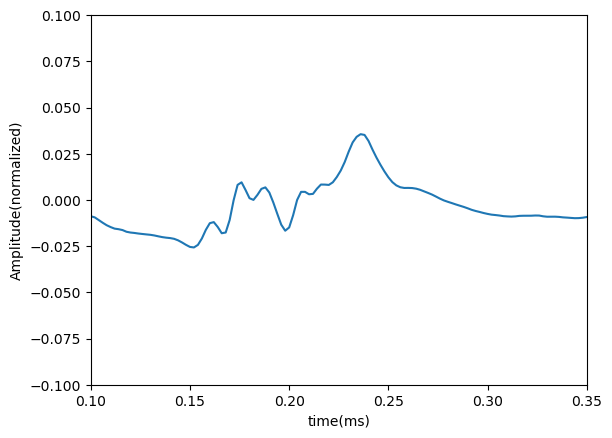

In [10]:
# first bubble signal zoom in 
plot_singal([0],x_lim=[0.1,0.35],y_lim=[-0.1,0.1])

#### Zoom in B2

signal detected by receivers: [0]


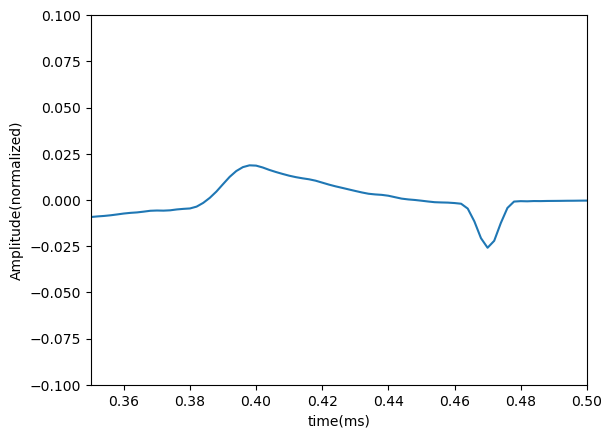

In [11]:
# second bubble signal zoom in 
plot_singal([0],x_lim=[0.35,0.50],y_lim=[-0.1,0.1])

### Signal from a receiver over time 

* You can see that the receiver signal has 2 visible peaks

* The fist one due to direct signal (probably), we need to verify this using time of flight 

* The other dominant peak (later to the first one) is coming from the signal reflected from the sea bed 

signal detected by receivers: [  1 101 201 301 401 501]


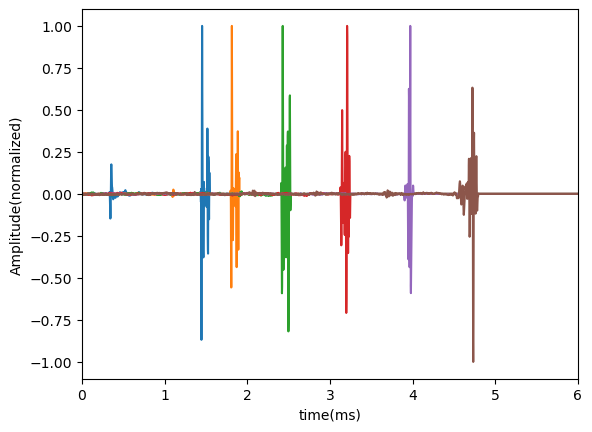

In [12]:
# signals detected by receiver #s [1,101,201,301,401,501]
receiver_arr = np.arange(1,601,100)
plot_singal(receiver_arr ,x_lim=[0,6])

signal detected by receivers: [ 1 11 21 31 41 51 61 71 81 91]


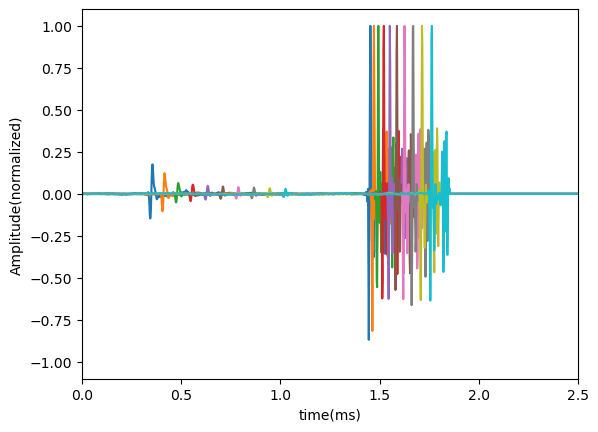

In [13]:
# signal detected by receivers upto 100 
receiver_arr = np.arange(1,101,10)
plot_singal(receiver_arr ,x_lim=[0,2.5])

#### Direct signal (plus the others: B1, B2, WC)

signal detected by receivers: [ 1 11 21 31 41 51 61 71 81 91]


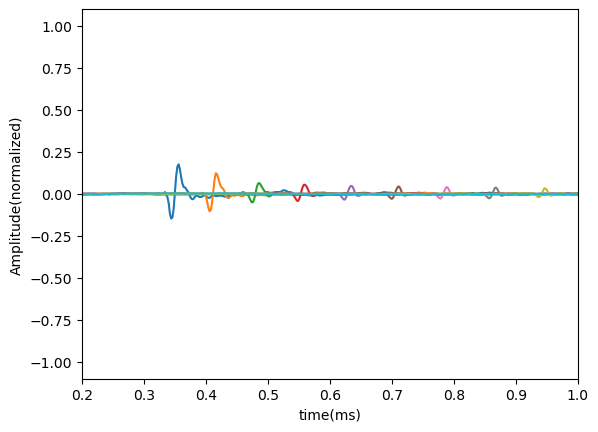

In [14]:
# zoom in the first part of the signals (probably from the water coloumns)
receiver_arr = np.arange(1,101,10)
plot_singal(receiver_arr ,x_lim=[0.2,1])

#### Reflected signal

signal detected by receivers: [ 1 11 21 31 41 51 61 71 81 91]


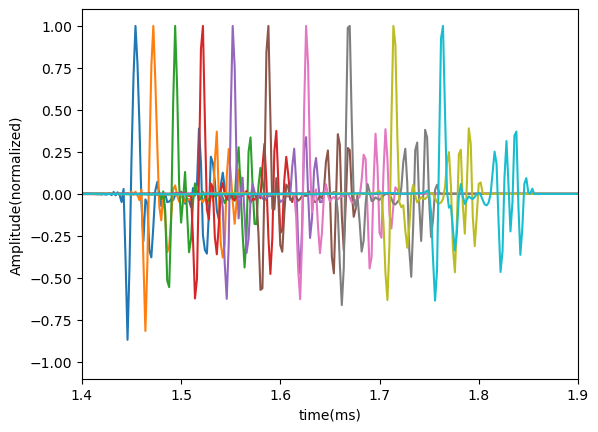

In [15]:
# zoom in second part of the signals (probably from the sea floor reflection)
receiver_arr = np.arange(1,101,10)
plot_singal(receiver_arr ,x_lim=[1.4,1.9])

signal detected by receivers: [10]


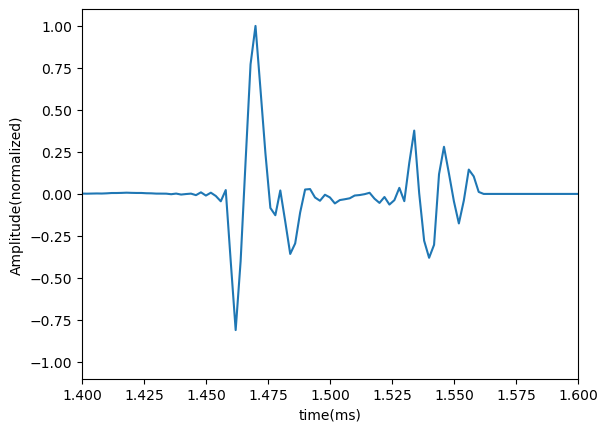

In [16]:
# this should be the singal reflected back from the sea bed and received by receiver 10 
plot_singal([10] ,x_lim=[1.4,1.6])

#### We need to more focus on the first region (before the reflected signal)?? 

* This region has direct signal as well as water column + B1 +B2 + BG signals 

* Our goal is to remove the B1, B2 and BG from this signal to focus on water column reflection signals 

signal detected by receivers: [10]


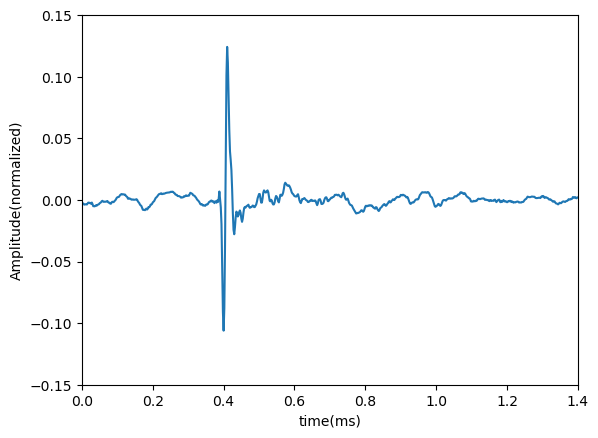

In [17]:
# then this should be the singal reflected back from water columns [+bublle + BG] and received by receiver 10
# or if we know the distance from source to the receiver it may be the direct signal D + (WC+B1+B2)
plot_singal([10] ,x_lim=[0,1.4],y_lim=[-0.15,0.15])

In [18]:
# frequency plot of singnal (FFT)
def freq_plot(signal,delta_t=2e-3,scaled_ss=False):
    ss = signal   
    n = len(ss)     
    time = np.arange(n)*delta_t

    f_ss = np.fft.fft(ss)            
    psd = np.sqrt(f_ss * np.conj(f_ss) /n)   
    max_psd = max(psd) 
    psd = psd/max_psd

    freq = np.fft.fftfreq(n)/delta_t        
    pos_freq = freq[freq>=0]
    
    f_ss0 = np.fft.fft(data[0])
    psd0 = np.sqrt(f_ss0 * np.conj(f_ss0) /n)
    max_psd0 = max(psd0)
    psd0 = psd0/max_psd0
    if scaled_ss:
        plt.plot(pos_freq,psd0[freq>=0],label='s0')
        
    plt.plot(pos_freq,psd[freq>=0],label=f's/s0 ={np.abs(max_psd/max_psd0):.8f}')
    plt.legend()
    plt.xlabel('freq(Hz)')
    plt.ylabel('psd')

### Moving away from the source

* As you can see bellow graphs when you move away from the source the amplitude (obviously) decreases

* Specially, you can notice that the higher freq. signals start disappearing as you move away from the source.  

/home/amara/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


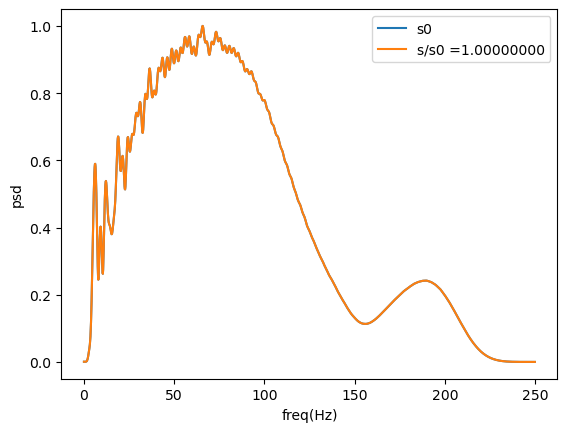

In [19]:
# normalized freq plot of the surce 
freq_plot(data[0],scaled_ss=True)

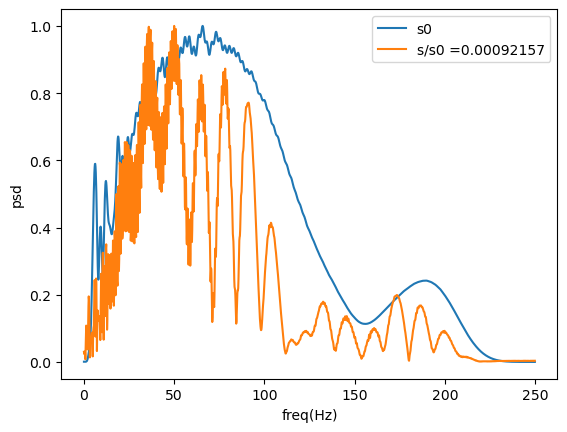

In [20]:
# freq plots of normalized source and receiver #10 signals 
freq_plot(data[10],scaled_ss=True)

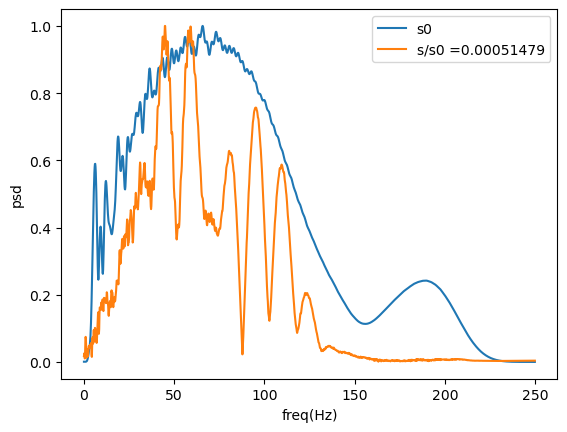

In [21]:
# freq plots of normalized source and receiver #100 signals 
freq_plot(data[100],scaled_ss=True)

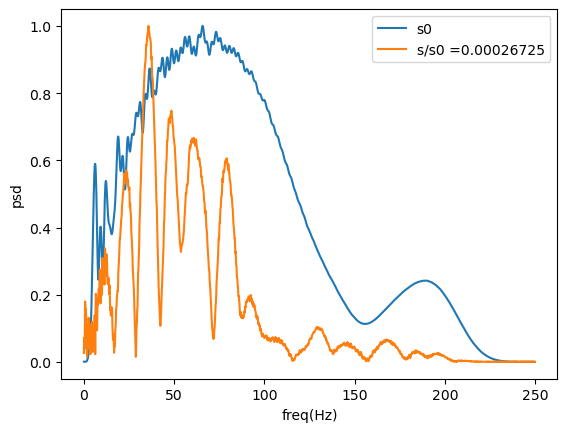

In [28]:
# freq plots of normalized source and receiver #200 signals 
freq_plot(data[200],scaled_ss=True)

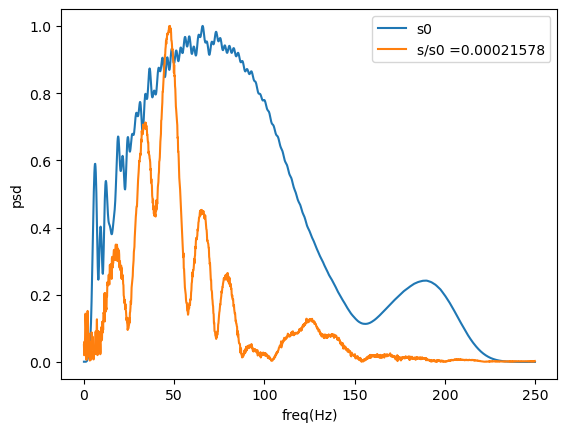

In [29]:
# freq plots of normalized source and receiver #300 signals 
freq_plot(data[300],scaled_ss=True)

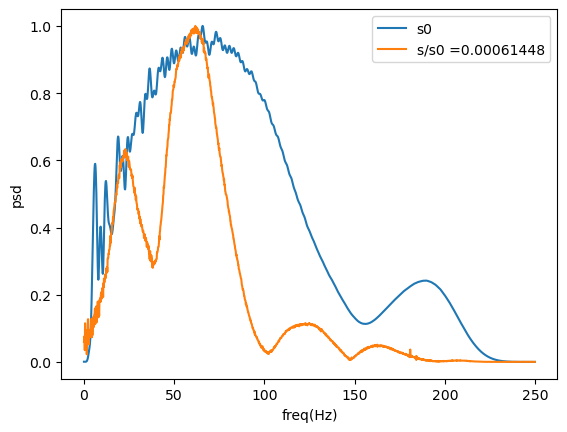

In [30]:
# freq plots of normalized source and receiver #400 signals 
freq_plot(data[400],scaled_ss=True)

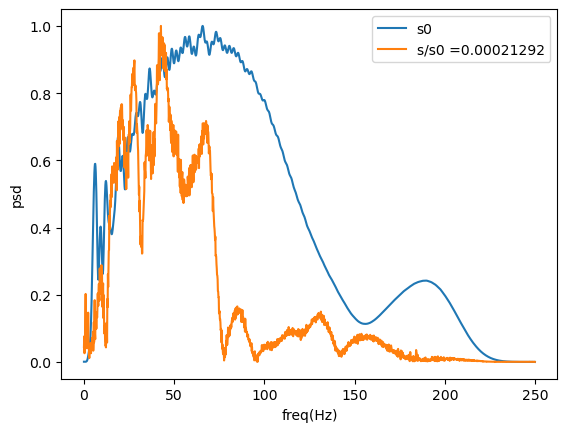

In [31]:
# freq plots of normalized source and receiver #500 signals 
freq_plot(data[500],scaled_ss=True)

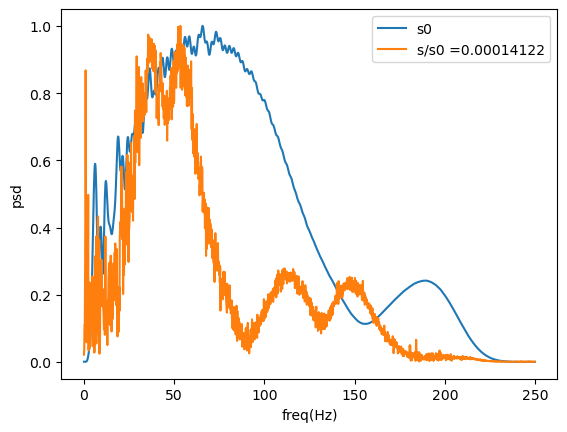

In [32]:
# freq plots of normalized source and receiver #600 signals 
freq_plot(data[600],scaled_ss=True)

In [22]:
# this plot the freq plot for given time interval 
def freq_plot_tcut(signal,t_min,t_max):
    ss = signal 
    n = len(ss) 
    delta_t=2e-3    
    time = np.arange(n)*delta_t

    time_mask = (time < t_max)*(time >t_min)

    masked_sig = ss*time_mask
    #masked_sig = masked_sig[masked_sig!=0]
    masked_sig

    freq_plot(masked_sig)
    

### The source signal (again)

* Here I am focusing on selecting the freq content of the direct signal and B1, B2

* We can separate these signals based on their times, so we extract these frequencies focusing on time windows (similar to ***Gabor*** transforms )

* As you can see, the source signal has freq spectrum ranging from 0-220 Hz (has one peak at 70 Hz and another ~ 180 Hz)

* The B1 and B2 has freq range of 0-100 Hz, with a peak around ~ 10Hz and 15 Hz respectively 

* These freq spectrums can be considered as characteristics of the signals 

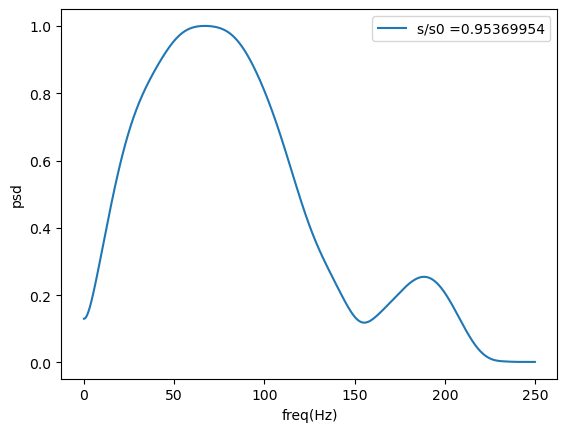

In [23]:
# source signal 
freq_plot_tcut(data[0],0,0.1)

[None, None, None]

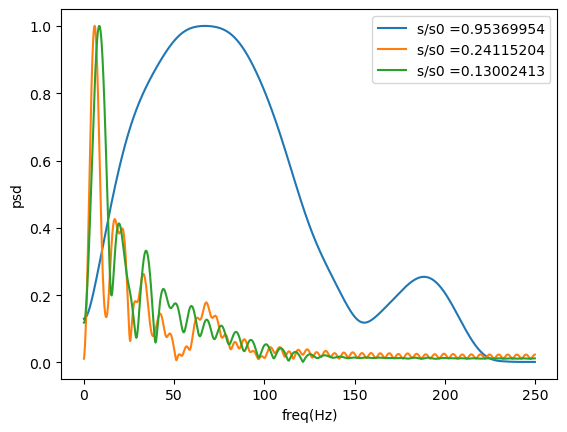

In [24]:
# source + B1 + B2 
[freq_plot_tcut(data[0],t_min,t_max) for t_min,t_max in [(0,0.1),(0.15,0.35),(0.35,.50)]]

### Change of freq content of receiver signal over time 

* At the beginning (of time) the receiver get the no signal (from the source) except the BG and has freq peak ~ 0 Hz

* Then as time progress, it is starting catching up the signals from source

[None, None, None, None]

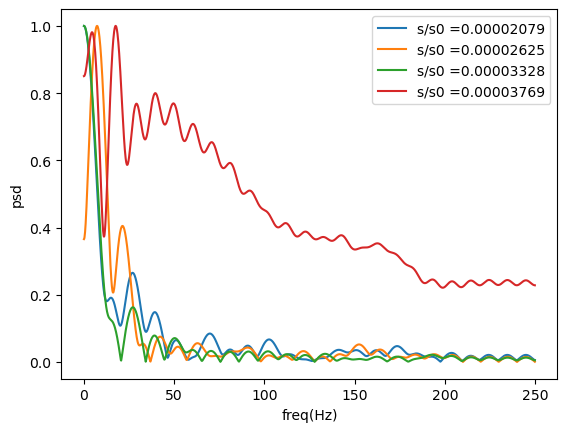

In [25]:
# freqs at receiver 10 @ different time windows 
[freq_plot_tcut(data[10],t_min,t_max) for t_min,t_max in [(0,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4)]]

[None, None, None, None, None, None, None, None, None, None]

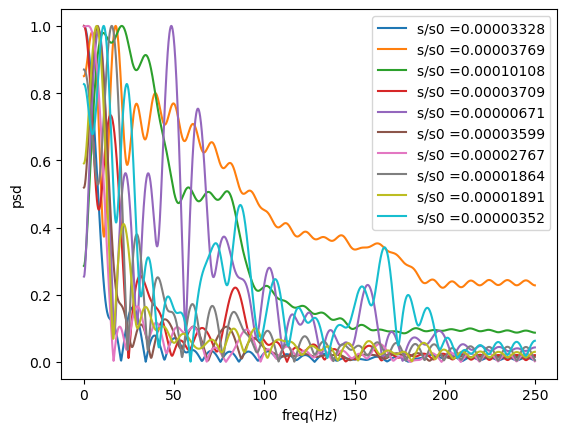

In [26]:
# freqs at receiver 10 @ different time windows 
time_int = [(0.2,0.3),(0.3,0.4),(0.4,0.5),(0.5,0.6),(0.6,0.7),(0.7,0.8),(0.8,0.9),(0.9,1.0),(1.0,1.1),(1.1,1.2)]
[freq_plot_tcut(data[10],t_min,t_max) for t_min,t_max in time_int]

[None, None, None, None]

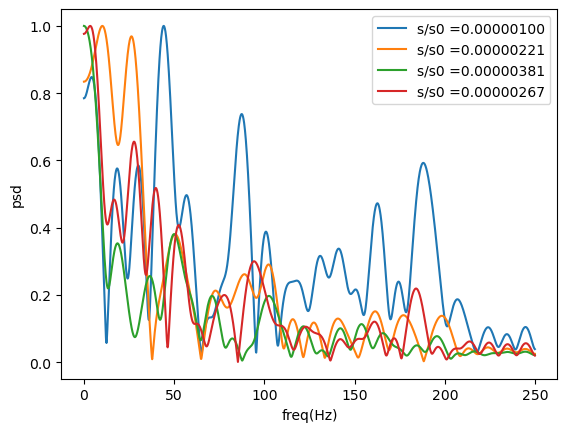

In [27]:
# freqs at receiver 100 @ different time windows 
[freq_plot_tcut(data[100],t_min,t_max) for t_min,t_max in [(0,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4)]]